# Baseline
- Try to classify investment opportunities (buy/sell) for upcoming IPO
- No NLP or fancy models
- Raw IPO listing data

In [1]:
#core
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import glob
import nasdaq
import ml
from bs4 import BeautifulSoup
from pathlib import Path

# Load NASDAQ IPO Performace

In [2]:
#load and sort by date priced
df = pd.read_csv('IPO Performance.csv', index_col='Symbol')
df['Date Priced'] = pd.to_datetime(df['Date Priced'], format='%Y-%m-%d')
df.sort_values(by='Date Priced', inplace=True)

### Preprocessing

In [3]:
#transform company name 
df.insert(0, 'Name Length', df['Company Name'].str.len())
df.insert(0, 'Name Words', df['Company Name'].str.split(' ').map(lambda x: len(x)))
df.drop(['Company Name'], axis=1, inplace=True)

#add quarter
df.insert(0, 'Q', df['Date Priced'].map(lambda x: pd.Period(x,'Q').quarter))

#add month
df.insert(0, 'Month', df['Date Priced'].dt.month)

df.drop(['Date Priced'], axis=1, inplace=True)

In [4]:
#encode market
df['Market'] = ml.encode(df, 'Market')

In [5]:
#to one hot encoding
df = pd.concat([pd.get_dummies(df['Market']).add_prefix('MKT'), df], axis=1)
df = pd.concat([pd.get_dummies(df['Month']).add_prefix('M'), df], axis=1)
df = pd.concat([pd.get_dummies(df['Q']).add_prefix('Q'), df], axis=1)
df.drop(['Market', 'Month', 'Q'], axis=1, inplace=True)

In [6]:
#standardize
cols_to_standardize = ['Name Words', 'Name Length', 'Offer Amount', 'Price', 'Shares']
df[cols_to_standardize] = ml.standardize(df[cols_to_standardize])

In [7]:
df.head(3)

,Q1,Q2,Q3,Q4,M1,M2,M3,M4,M5,M6,...,MKT12,Name Words,Name Length,Offer Amount,Price,Shares,1D,1W,1M,3M
Symbol,,,,,,,,,,,,,,,,,,,,,
WQNI,1,0,0,0,0,1,0,0,0,0,...,0,-1.183553,-1.611300,-0.284726,-0.340497,-0.386568,-0.129856,-0.296122,0.088818,-0.667432
BBGI,1,0,0,0,0,1,0,0,0,0,...,0,0.950208,0.701675,-0.206002,-0.038392,-0.261148,-0.058333,-0.133333,-0.175000,-0.250000
UTSI,1,0,0,0,0,0,1,0,0,0,...,0,-0.116672,0.316180,-0.123477,0.263712,-0.164788,0.512195,0.448171,1.042683,-0.134146


In [8]:
#as expected the results are poor
ml.run_ml_flow(df)

,1D,1W,1M,3M
AUC,0.514154,0.468991,0.482075,0.483895
f1,0.417722,0.541284,0.635294,0.567568
log loss,0.697682,0.713322,0.719962,0.723912


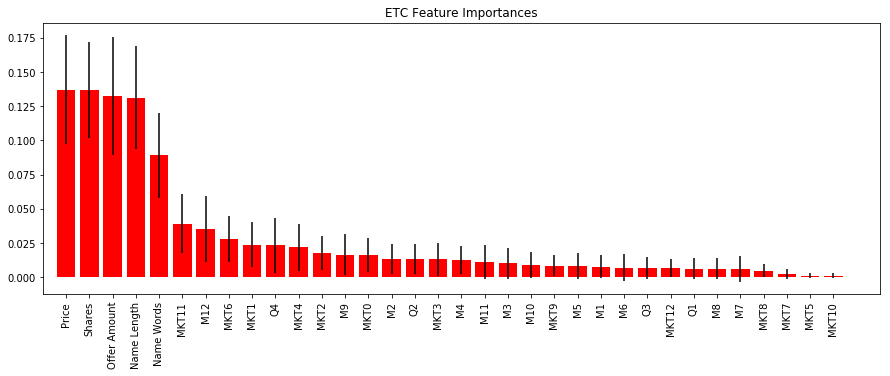

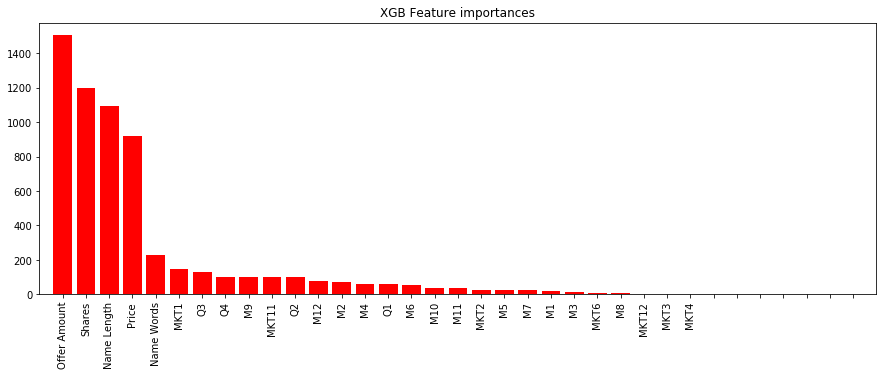

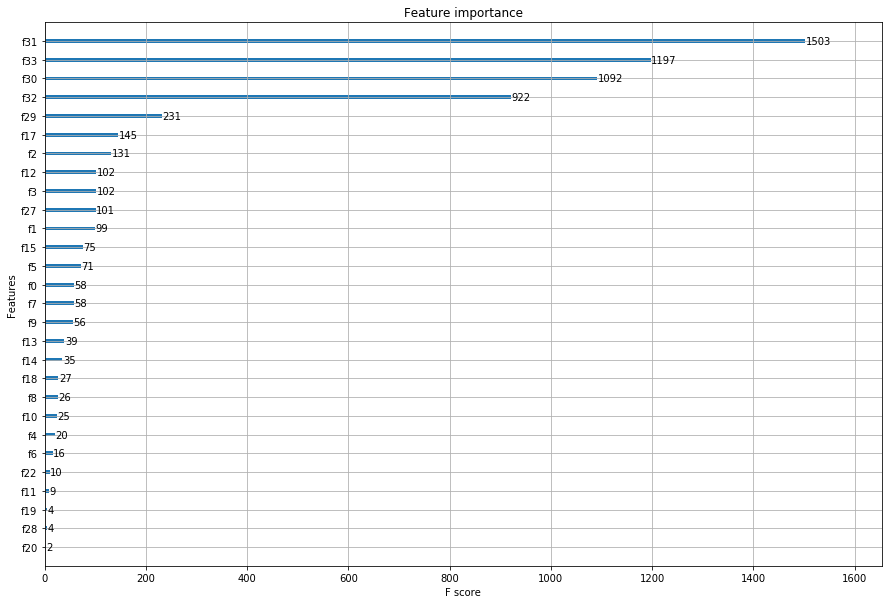

In [9]:
X, Y = df.values[:,:-4], df['3M'].map(lambda x: 1 if x > 0 else 0).values
indices_sklearn = ml.rank_features_etc(X, Y, df.columns[:-4])
indices_xgb = ml.rank_features_xgb(X, Y, df.columns[:-4])

In [ ]:
#save for later improvements
df.to_csv('1 baseline.csv', index=False)